### Import Libraries and Modules
First we load the core Python libraries needed throughout the analysis. Importing the necessary Python libraries (e.g., `pandas`, `numpy`, `matplotlib`) and custom ODYM modules to ensure that all functions, classes, and utilities are available in the session. Without this step, subsequent code cells may fail with missing‐import errors, disrupting the workflow. Establishing a consistent environment at the outset also makes the notebook more portable and reproducible for other users.


In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import odym.classes as msc
import odym.functions as msf
import odym.dynamic_stock_model as dsm
import os

### Define Data Paths and Load Data
Next, we point to the data directory and Excel workbooks containing the fiber-composition, and production data are loaded into structured DataFrames. Early loading of data allowed file-format or path errors to be identified immediately.


In [53]:
DATA_PATH = os.path.join(os.path.dirname(os.getcwd()), "data")

df_composition = pd.read_excel(os.path.join(DATA_PATH, "clustered_fiber_composition.xlsx"))

### Extract Clothing Types and Fiber Composition Data
Here we isolate the list of product categories (clothing types) and identify the columns representing raw-material fibers to focus subsequent calculations on relevant inputs. By clearly defining inputs, the risk of logical errors in flow calculations is reduced and code organization is enhanced.



In [54]:
clothing_type = list(df_composition["Clothing type"])
clothing_type

['t-shirts',
 'trousers',
 'overcoats',
 'underwear',
 'handkerchiefs_1',
 'shirts_1',
 'sportswear',
 'handkerchiefs_2',
 'shirts_2',
 'sweaters']

In [55]:
meta_columns = ['Category', 'Sum', 'Cluster', 'Count', 'Market share', 'Category share', 'Lifetime Min', 'Lifetime Max', 'Clothing type', 'Fibre composition sum']
fibers = df_composition.columns[~df_composition.columns.isin(meta_columns)].tolist()
fibers

['Acrylic',
 'Cotton',
 'Polyamide/nylon',
 'Polyester',
 'Silk',
 'Viscose',
 'Wool',
 'Animal hair']

### Define Time Horizon (Quarters)
We generate a standardized sequence of Quarter labels (e.g., `"2016Q1"` through `"2022Q4"`) to serve as the model’s time index. Establishing a consistent time axis enabled alignment of inflows, outflows, and stock changes across periods and simplified temporal analysis and visualization. A quarterly interval has been selected to provide sufficient temporal resolution: monthly data would have introduced excessive fragmentation and noise, while annual intervals risked obscuring meaningful trends and intermediate variations in material flows.   



In [56]:
quarters = [f"{year}Q{q}" for year in range(2016, 2023) for q in range(1, 5)]
quarters

['2016Q1',
 '2016Q2',
 '2016Q3',
 '2016Q4',
 '2017Q1',
 '2017Q2',
 '2017Q3',
 '2017Q4',
 '2018Q1',
 '2018Q2',
 '2018Q3',
 '2018Q4',
 '2019Q1',
 '2019Q2',
 '2019Q3',
 '2019Q4',
 '2020Q1',
 '2020Q2',
 '2020Q3',
 '2020Q4',
 '2021Q1',
 '2021Q2',
 '2021Q3',
 '2021Q4',
 '2022Q1',
 '2022Q2',
 '2022Q3',
 '2022Q4']

In [57]:
df_production = pd.read_excel(os.path.join(DATA_PATH, "clothing_production_interpolated.xlsx"), index_col=0)

# Split each year's value into 4 quarters (equal distribution)
quarters = []
for year in df_production.columns:
    for q in range(1, 5):
        quarters.append(f"{year}Q{q}")

df_production_quarterly = pd.DataFrame(
    np.repeat(df_production.values / 4, 4, axis=1),
    index=df_production.index,
    columns=quarters
)
# Remove the 'total' row if present
df_production_quarterly = df_production_quarterly.drop('total', errors='ignore')
df_production_quarterly

,2016Q1,2016Q2,2016Q3,2016Q4,2017Q1,2017Q2,2017Q3,2017Q4,2018Q1,2018Q2,...,2020Q3,2020Q4,2021Q1,2021Q2,2021Q3,2021Q4,2022Q1,2022Q2,2022Q3,2022Q4
Product category,,,,,,,,,,,,,,,,,,,,,
overcoats and anoraks,1198.25,1198.25,1198.25,1198.25,1425.25,1425.25,1425.25,1425.25,1652.00,1652.00,...,2106.00,2106.00,2332.75,2332.75,2332.75,2332.75,2559.75,2559.75,2559.75,2559.75
suits and blazers,799.50,799.50,799.50,799.50,879.25,879.25,879.25,879.25,959.00,959.00,...,1118.50,1118.50,1198.25,1198.25,1198.25,1198.25,1278.00,1278.00,1278.00,1278.00
trousers and shorts,3479.75,3479.75,3479.75,3479.75,3926.50,3926.50,3926.50,3926.50,4373.50,4373.50,...,5267.25,5267.25,5714.00,5714.00,5714.00,5714.00,6161.00,6161.00,6161.00,6161.00
dresses and skirts,676.75,676.75,676.75,676.75,784.75,784.75,784.75,784.75,892.75,892.75,...,1108.75,1108.75,1216.75,1216.75,1216.75,1216.75,1324.75,1324.75,1324.75,1324.75
"shirts, blouses, tops",1437.50,1437.50,1437.50,1437.50,1371.00,1371.00,1371.00,1371.00,1304.75,1304.75,...,1172.00,1172.00,1105.50,1105.50,1105.50,1105.50,1039.25,1039.25,1039.25,1039.25
"underwear, socks, and night clothes",1784.00,1784.00,1784.00,1784.00,1773.75,1773.75,1773.75,1773.75,1763.50,1763.50,...,1742.75,1742.75,1732.50,1732.50,1732.50,1732.50,1722.25,1722.25,1722.25,1722.25
t-shirts and vests,2262.00,2262.00,2262.00,2262.00,2338.75,2338.75,2338.75,2338.75,2415.50,2415.50,...,2568.75,2568.75,2645.50,2645.50,2645.50,2645.50,2722.25,2722.25,2722.25,2722.25
sweaters and cardigans,2282.50,2282.50,2282.50,2282.50,2514.75,2514.75,2514.75,2514.75,2747.00,2747.00,...,3211.25,3211.25,3443.50,3443.50,3443.50,3443.50,3675.75,3675.75,3675.75,3675.75
sportswear and swimwear,335.75,335.75,335.75,335.75,879.75,879.75,879.75,879.75,1423.75,1423.75,...,2512.00,2512.00,3056.00,3056.00,3056.00,3056.00,3600.00,3600.00,3600.00,3600.00


### Computing the Survival Matrix for Clothing Lifetimes  
Next, we construct a probabilistic survival matrix by converting minimum and maximum lifespans of the clothing types into a distribution of phase-out rates over time. This models how clothing types transition from active use to end-of-life, enabling time-sensitive calculations of discard flows within the dynamic system.

In [58]:
import numpy as np
import pandas as pd
from scipy.stats import norm

def compute_survival_matrix(df_composition, quarters):
    min_life = df_composition['Lifetime Min'].values * 4  # in quarters
    max_life = df_composition['Lifetime Max'].values * 4  # in quarters

    mu = (min_life + max_life) / 2
    sigma = np.maximum((max_life - min_life) / 4, 1.0)

    x = np.arange(len(quarters))
    prob_matrix = norm.pdf(x[None, :], loc=mu[:, None], scale=sigma[:, None])

    # Handle zero-variance edge case: replace rows where sigma == 0 with Dirac delta
    is_delta = sigma == 0
    if np.any(is_delta):
        prob_matrix[is_delta] = 0
        peak_positions = mu[is_delta].astype(int).clip(0, len(x)-1)
        prob_matrix[is_delta, peak_positions] = 1

    # Normalize rows to sum to 1
    prob_matrix /= prob_matrix.sum(axis=1, keepdims=True)
    survival_matrix = 1 - np.cumsum(prob_matrix, axis=1)

    # Ensure numerical stability
    survival_matrix[:, 0] = 1.0
    survival_matrix[:, -1] = 0.0
    survival_matrix = np.clip(survival_matrix, 0.0, 1.0)
    return survival_matrix

# Example usage:
survival_matrix = compute_survival_matrix(df_composition, quarters)



### Defining Model Classifications  
We now define a classification dictionary to formalize the model dimensions like time, age cohorts, fiber elements, and clothing types. This step allows efficient referencing and consistent indexing across system variables, simplifying looping operations and improving clarity of the overall MFA architecture.


In [59]:
ModelClassification  = {} # Create dictionary of model classifications

ModelClassification['Time'] = msc.Classification(
    Name='Time',
    Dimension='Time',
    ID=1,
    Items=range(len(quarters)),

)

ModelClassification['Age_Cohort'] = msc.Classification(
    Name='Age Cohort',
    Dimension='Time',
    ID=2,
    Items=ModelClassification['Time'].Items,
)

ModelClassification['Element'] = msc.Classification(
    Name='Fibers',
    Dimension='Element',
    ID=3,
    Items= fibers,
)

ModelClassification["Clothing"] = msc.Classification(
    Name='Clothing Type',
    Dimension='Clothing',
    ID=4,
    Items = clothing_type,
)   

Model_Time_Start = int(min(ModelClassification['Time'].Items))
Model_Time_End   = int(max(ModelClassification['Time'].Items))
Model_Duration   = Model_Time_End - Model_Time_Start

### Creating the Index Table for the MFA System  
Next, we define aspects and map each classification label to a unique index letter in a compact index table. This table underlies the `Dyn_MFA_System` initialization, enables efficient handling of multi-dimensional arrays and supports fast computation during MFA simulation by avoiding repetitive string operations.


In [60]:
IndexTable = pd.DataFrame({'Aspect'        : ['Time', 'Age_Cohort', 'Element','Clothing'], # 'Time' and 'Element' must be present!
                           'Description'   : ['Model aspect "time"', 'Model aspect "age cohort"','Model aspect "fiber type"', 'Model aspect "clothing type"'],
                           'Dimension'     : ['Time','Time','Element','Clothing'], # 'Time' and 'Element' are also dimensions
                           'Classification': [ModelClassification[Aspect] for Aspect in ['Time','Age_Cohort','Element', 'Clothing']],
                           'IndexLetter'   : ['t','a','e','c']}) # Unique one letter (upper or lower case) indices to be used later for calculations.

IndexTable.set_index('Aspect', inplace = True) # Default indexing of IndexTable, other indices are produced on the fly

IndexTable

,Description,Dimension,Classification,IndexLetter
Aspect,,,,
Time,"Model aspect ""time""",Time,<odym.classes.classification.Classification ob...,t
Age_Cohort,"Model aspect ""age cohort""",Time,<odym.classes.classification.Classification ob...,a
Element,"Model aspect ""fiber type""",Element,<odym.classes.classification.Classification ob...,e
Clothing,"Model aspect ""clothing type""",Clothing,<odym.classes.classification.Classification ob...,c


### Initializing the Dynamic MFA System  
Now we create the `Dyn_MFA_System` object with all the core data structures for the simulation. This initialization sets up the memory structure, metadata, and dimensionality required to execute a full-scale dynamic material flow simulation.


In [61]:
Dyn_MFA_System = msc.MFAsystem(
    Name='Clothing Cycle in Households', 
    Geogr_Scope='Denmark', 
    Unit='t', 
    ProcessList=[], 
    FlowDict={}, 
    StockDict={},
    ParameterDict={}, 
    Time_Start=Model_Time_Start, 
    Time_End=Model_Time_End, 
    IndexTable=IndexTable, 
    Elements=IndexTable.loc['Element'].Classification.Items
)
Dyn_MFA_System.IndexTableCheck() 

True

### Defining Processes in the MFA System  
Next, we point and define each process in the system by appending them to `Dyn_MFA_System.ProcessList`, specifying all the pathways through which materials travel. These clear process definitions are the blueprint for our mass flows. Accurate and comprehensive listing here ensures that no material flows are overlooked in the simulation.

In [62]:
# Start with empty process list, only process numbers (IDs) and names are needed.
Dyn_MFA_System.ProcessList = [] 
Dyn_MFA_System.ProcessList.append(msc.Process(Name = 'Environment' , ID   = 0))
Dyn_MFA_System.ProcessList.append(msc.Process(Name = 'Store'    , ID   = 1))
Dyn_MFA_System.ProcessList.append(msc.Process(Name = 'Consumer'  , ID   = 2))
Dyn_MFA_System.ProcessList.append(msc.Process(Name = 'Sorting Facility'   , ID   = 3))
Dyn_MFA_System.ProcessList.append(msc.Process(Name = 'Recycling Facility'   , ID   = 4))

# Print list of processes:
Dyn_MFA_System.ProcessList

In [63]:
np.random.seed(42)
Par_Reuse_Share = np.random.uniform(0.1, 0.3, len(quarters))
Par_Recycling_Share = np.linspace(0.3, 0.5, len(quarters))

Par_Clothing_Composition = df_composition[df_composition['Clothing type'].isin(clothing_type)][fibers].to_numpy()
Par_Clothing_Category_Share = df_composition[df_composition['Clothing type'].isin(clothing_type)]['Category share'].to_numpy()
Par_Clothing_Production = df_production_quarterly.to_numpy()
Par_Clothing_Survival = survival_matrix

Par_Initial_Stock = np.ones((len(clothing_type), len(fibers)))*1000

### Setting Model Parameters  
We then use `ParameterDict` to assign values for production inflows, survival‐rate parameters, recycling and reuse shares, and any initial stock levels.  These parameters control the magnitude and timing of all flows and stocks and act as behavioral drivers for the system, later supporting scenario analysis, calibration, and sensitivity testing.


In [64]:

ParameterDict = {}

ParameterDict['F_0_1']  = msc.Parameter(Name = 'Inflow_Clothing', ID = 1, P_Res = 1,
                                        MetaData = None, Indices = 'tec',
                                        Values = np.einsum("ce,c,ct->tec",Par_Clothing_Composition,Par_Clothing_Category_Share,Par_Clothing_Production), 
                                        Unit = 't/yr')
ParameterDict['Survival_Rate'] = msc.Parameter(Name = 'Survival Rate', ID = 2, P_Res = 2,
                                        MetaData = None, Indices = 'ca',
                                        Values = Par_Clothing_Survival, 
                                        Unit = '1/yr')
ParameterDict['Gamma_1']  = msc.Parameter(Name = 'Share of recyclable clothing', ID = 3, P_Res = 3,
                                        MetaData = None, Indices = 't',
                                        Values = Par_Recycling_Share, 
                                        Unit = '1')
ParameterDict['Gamma_2']  = msc.Parameter(Name = 'Share of reusable clothing', ID = 4, P_Res = 3,
                                        MetaData = None, Indices = 't',
                                        Values = Par_Reuse_Share, 
                                        Unit = '1')
ParameterDict['S_2_init'] = msc.Parameter(Name = 'Initial Stock', ID = 5, P_Res = 2,
                                        MetaData = None, Indices = 'ec',
                                        Values = np.zeros((len(fibers), len(clothing_type))), 
                                        Unit = 't')
Dyn_MFA_System.ParameterDict = ParameterDict

### Defining Flows and Stocks and Initializing Values  
Each flow and stock variable—ranging from production inflow and in-use accumulation to recycling and net change—is registered in the model and initialized to defined starting and ending values. This prevents undefined behaviors and ensures numerical consistency throughout the simulation period.


In [65]:
Dyn_MFA_System.FlowDict['F_0_1'] = msc.Flow(Name = 'Clothing Production', P_Start = 0, P_End = 1,
                                            Indices = 't,e,c', Values=None)
Dyn_MFA_System.FlowDict['F_1_2'] = msc.Flow(Name = 'Clothing Sale', P_Start = 1, P_End = 2,
                                            Indices = 't,e,c', Values=None)
Dyn_MFA_System.FlowDict['F_2_3'] = msc.Flow(Name = 'Clothing Discard', P_Start = 2, P_End = 3,
                                            Indices = 't,e,c', Values=None)
Dyn_MFA_System.FlowDict['F_3_4'] = msc.Flow(Name = 'Clothing Recycling', P_Start = 3, P_End = 4,
                                            Indices = 't,e', Values=None)
Dyn_MFA_System.FlowDict['F_3_1'] = msc.Flow(Name = 'Clothing Reuse', P_Start = 3, P_End = 1,
                                            Indices = 't,e,c', Values=None)
Dyn_MFA_System.FlowDict['F_3_0'] = msc.Flow(Name = 'Clothing Incineration', P_Start = 3, P_End = 0,
                                            Indices = 't,e', Values=None)
Dyn_MFA_System.FlowDict['F_4_0'] = msc.Flow(Name = 'Recycled Fibers', P_Start = 4, P_End = 0,
                                            Indices = 't,e', Values=None)
                                            
Dyn_MFA_System.StockDict['S_2']  = msc.Stock(Name = 'In-use stock', P_Res = 2, Type = 0,
                                            Indices = 't,a,e,c', Values=None, Uncert=None,
                                            ID = None, UUID = None)

Dyn_MFA_System.StockDict['dS_2']  = msc.Stock(Name = 'Net in-use stock change', P_Res = 2, Type = 1,
                                               Indices = 't,e,c', Values=None, Uncert=None,
                                               ID = None, UUID = None)

Dyn_MFA_System.Initialize_StockValues()
Dyn_MFA_System.Initialize_FlowValues()

### Programming the Dynamic MFA Solution  
We execute the `run_dyn_mfa` function by applying mass-balance equations across each time step. Using survival matrices and parameter values, it dynamically updates flows and stocks to generate time-resolved outputs. This step forms the computational engine of the model, translating assumptions and inputs into material flow trajectories and generating the time series data for analysis.




In [66]:

def run_dyn_mfa(Dyn_MFA_System):
    duration = len(ModelClassification['Time'].Items)  # T
    num_ages = len(ModelClassification['Age_Cohort'].Items)

    # Load model parameters
    inflow_param = Dyn_MFA_System.ParameterDict['F_0_1'].Values      # (t, e, c)
    survival_rate = Dyn_MFA_System.ParameterDict['Survival_Rate'].Values.T  # (a, c)
    gamma_rec = Dyn_MFA_System.ParameterDict['Gamma_1'].Values       # (t,) or scalar
    gamma_use = Dyn_MFA_System.ParameterDict['Gamma_2'].Values       # (t,) or scalar
    init_stock = Dyn_MFA_System.ParameterDict['S_2_init'].Values     # (e, c)

    # Get flow and stock references
    F01 = Dyn_MFA_System.FlowDict['F_0_1'].Values
    F12 = Dyn_MFA_System.FlowDict['F_1_2'].Values
    F23 = Dyn_MFA_System.FlowDict['F_2_3'].Values
    F31 = Dyn_MFA_System.FlowDict['F_3_1'].Values
    F30 = Dyn_MFA_System.FlowDict['F_3_0'].Values
    F34 = Dyn_MFA_System.FlowDict['F_3_4'].Values
    F40 = Dyn_MFA_System.FlowDict['F_4_0'].Values

    S2 = Dyn_MFA_System.StockDict['S_2'].Values
    dS2 = Dyn_MFA_System.StockDict['dS_2'].Values

    # Initialize first year stock across all age cohorts
    S2[0, :, :, :] = init_stock[None, :, :]  # (a, e, c)

    # Precompute survival and death rates for broadcasting
    survival = survival_rate[:, None, :]           # (a, 1, c)
    mortality = 1 - survival

    for t in range(duration):
        # --- Step 1: Compute waste due to depreciation ---
        current_cohorts = S2[t]                      # (a, e, c)
        deaths = mortality * current_cohorts         # (a, e, c)
        F23[t] = deaths.sum(axis=0)                  # (e, c)

        # --- Step 2: Sorting facility outputs ---
        gamma_rec_t = gamma_rec[t]
        gamma_use_t = gamma_use[t]
        residual_frac = 1 - gamma_rec_t - gamma_use_t

        F34[t] = np.sum(gamma_rec_t * F23[t], axis=1)  # to recycling (e,)
        F31[t] = gamma_use_t * F23[t]                  # reuse (e, c)
        F30[t] = np.sum(residual_frac * F23[t], axis=1)  # disposal (e,)

        # --- Step 3: Inflow and reuse ---
        F01[t] = inflow_param[t]                       # new inflows
        F12[t] = F01[t] + F31[t]                       # total to in-use stock

        # --- Step 4: Age the stock cohorts ---
        if t < duration - 1:
            S2[t + 1, 0] = F12[t]  # new stock enters cohort 0
            for a in range(1, num_ages):
                S2[t + 1, a] = survival[a - 1] * S2[t, a - 1]

        # --- Step 5: Recycled flow to environment ---
        F40[t] = F34[t]

        # --- Step 6: Compute net stock change ---
        total_now = S2[t].sum(axis=0)
        total_next = S2[t + 1].sum(axis=0) if t < duration - 1 else total_now
        dS2[t] = total_next - total_now

    return Dyn_MFA_System

# Run model with internal durations and age cohorts
Dyn_MFA_System = run_dyn_mfa(Dyn_MFA_System)
Dyn_MFA_System.Consistency_Check()


(True, True, True)

### Performing the Mass-Balance Check  
After the simulation runs, we invoke the `Dyn_MFA_System.MassBalance()` method to verify that the model adheres to the principle of mass conservation—ensuring that inflows equal the sum of outflows and stock changes at each time step. This post-simulation check serves as a quality control measure to detect any inconsistencies or implementation errors, confirming the internal validity of the system.

In [67]:
Bal = Dyn_MFA_System.MassBalance()
print(Bal.shape) # dimensions of balance are: time step x process x chemical element
print(np.abs(Bal).sum(axis=(0))) # reports the sum of all absolute balancing errors by process (sum over time and element).

(28, 5, 8)
[[1.22878853e+02 1.45652857e+03 1.41847458e+02 2.86266134e+03
  5.40947226e+01 1.75480197e+01 1.70736400e+02 3.28494947e+01]
 [5.02616033e-13 4.96664929e-12 6.88444191e-13 1.50497901e-11
  9.60348026e-14 8.42453972e-14 3.34810949e-13 1.14153128e-13]
 [1.22878853e+02 1.45652857e+03 1.41847458e+02 2.86266134e+03
  5.40947226e+01 1.75480197e+01 1.70736400e+02 3.28494947e+01]
 [1.95427015e-13 2.69218003e-12 1.65257622e-13 2.16206393e-12
  2.51049215e-14 2.88692689e-14 2.42529101e-13 3.38687412e-14]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]


In [ ]:
SCENARIO_NAME = 'Original Scenario'
description = 'Based on the oroignal production data with 10 clustered  distinct clothing types representing a market share of >50%'
EXPORT_PATH = os.path.join(DATA_PATH, "mfa_export.xlsx")

# Sum recycling and incineration flows over time, keep fiber type (axis=0: time, axis=1: fiber)
F34 = Dyn_MFA_System.FlowDict['F_3_4'].Values  # (t, e)
F30 = Dyn_MFA_System.FlowDict['F_3_0'].Values  # (t, e)

recycling_by_fiber = F34.sum(axis=0)      # shape: (e,)
incineration_by_fiber = F30.sum(axis=0)   # shape: (e,)

if not os.path.exists(EXPORT_PATH):
    # Create new DataFrames for recycling and incineration
    recycling_df = pd.DataFrame({SCENARIO_NAME: recycling_by_fiber}, index=fibers)
    incineration_df = pd.DataFrame({SCENARIO_NAME: incineration_by_fiber}, index=fibers)
    with pd.ExcelWriter(EXPORT_PATH, engine='xlsxwriter') as writer:
        recycling_df.to_excel(writer, sheet_name='Recycling')
        incineration_df.to_excel(writer, sheet_name='Incineration')
else:
    # Load existing Excel file and add new scenario column
    with pd.ExcelFile(EXPORT_PATH) as reader:
        recycling_df = pd.read_excel(reader, sheet_name='Recycling', index_col=0)
        incineration_df = pd.read_excel(reader, sheet_name='Incineration', index_col=0)
    recycling_df[SCENARIO_NAME] = recycling_by_fiber
    incineration_df[SCENARIO_NAME] = incineration_by_fiber
    with pd.ExcelWriter(EXPORT_PATH, engine='xlsxwriter') as writer:
        recycling_df.to_excel(writer, sheet_name='Recycling')
        incineration_df.to_excel(writer, sheet_name='Incineration')



### Plotting MFA Flows and Stocks  
We also define a plotting function and generate visualizations of key flows and stock levels over time to transform raw numbers into intuitive graphs. These plots reveal trends such as stock accumulation, peak discard periods, and the proportional roles of recycling, reuse, and final treatment. 



Plotting flow: Clothing Production with indices ['t', 'e', 'c']


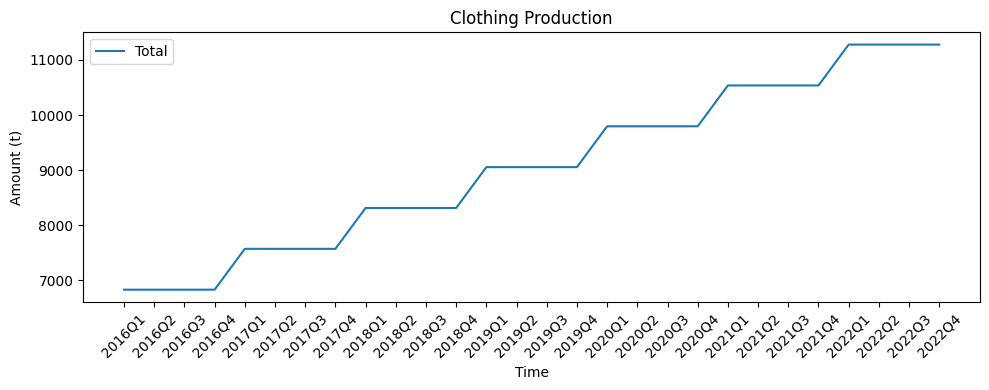

Plotting flow: Clothing Sale with indices ['t', 'e', 'c']


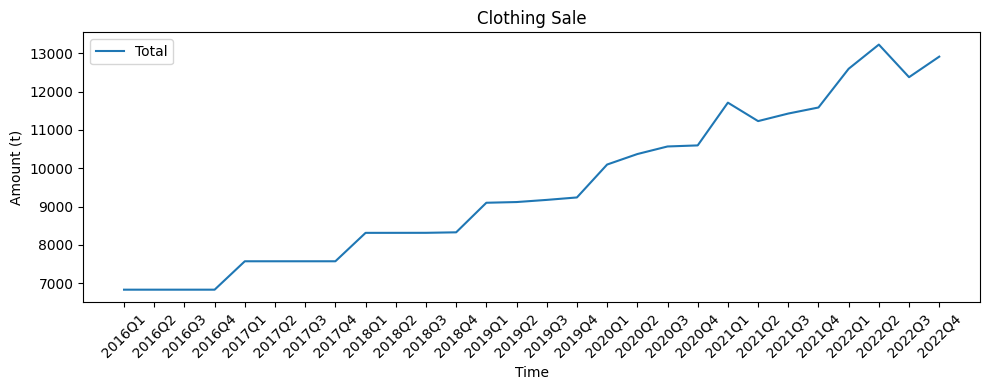

Plotting flow: Clothing Discard with indices ['t', 'e', 'c']


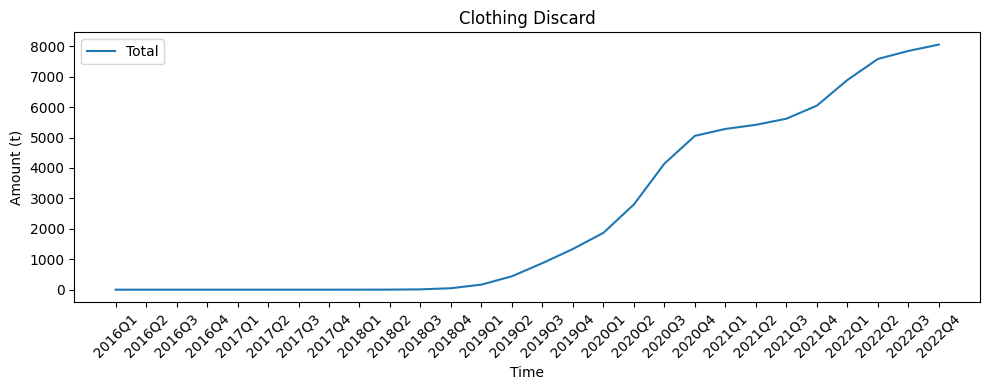

Plotting flow: Clothing Recycling with indices ['t', 'e']


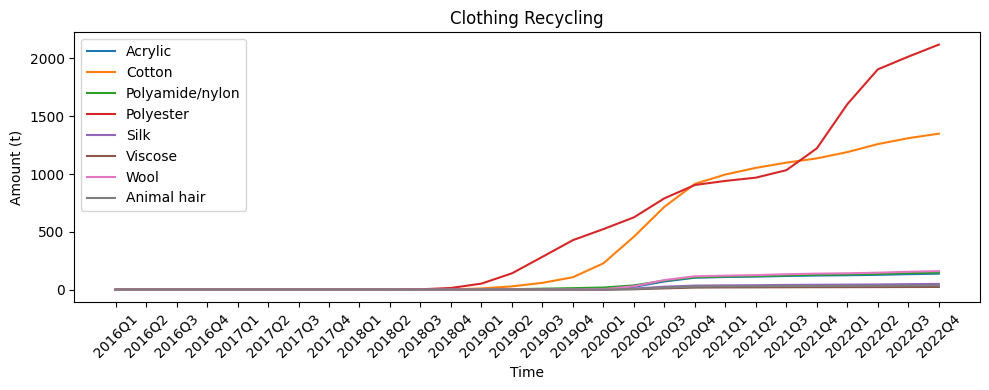

Plotting flow: Clothing Reuse with indices ['t', 'e', 'c']


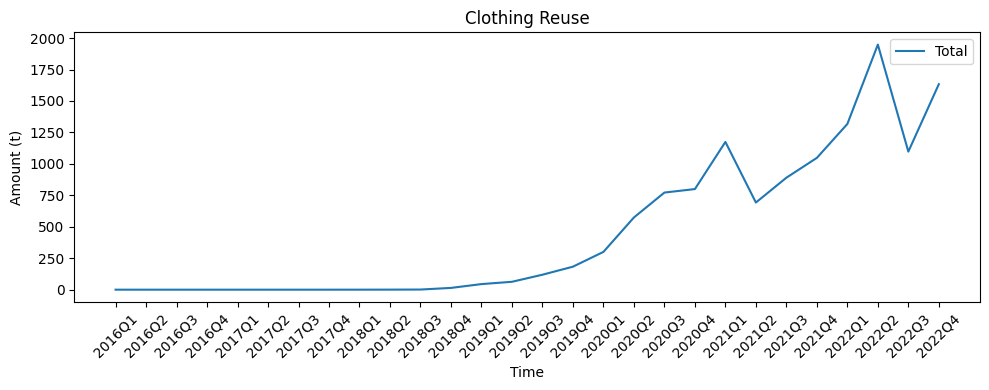

Plotting flow: Clothing Incineration with indices ['t', 'e']


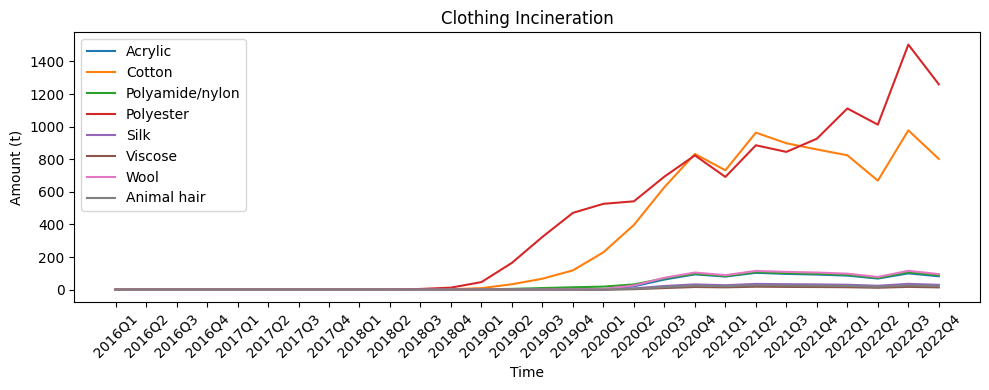

Plotting flow: Recycled Fibers with indices ['t', 'e']


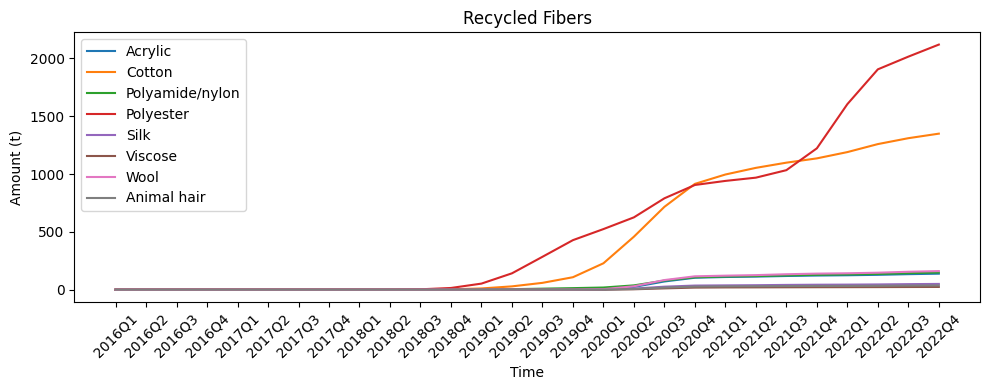

Plotting stock: In-use stock with indices t,a,e,c


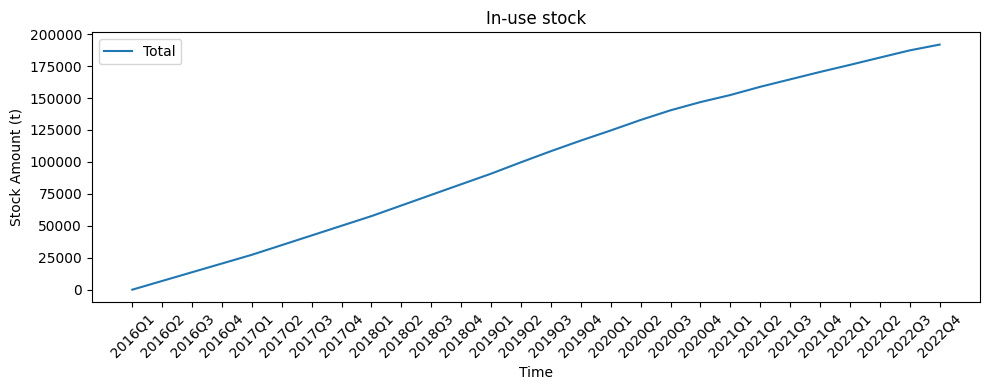

Plotting stock: Net in-use stock change with indices t,e,c


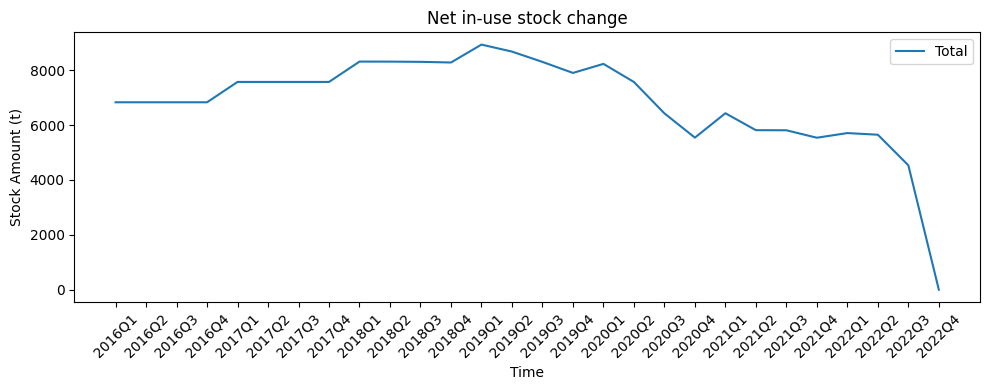

In [68]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mfa_flows(Dyn_MFA_System, quarters):
    """
    Automatically plots flows and stocks based on Dyn_MFA_System content and metadata.
    """
    dimension_labels = {
        'e': ModelClassification['Element'].Items,
        'c': ModelClassification['Clothing'].Items,
        'a': quarters,
        't': quarters
    }

    def get_labels_for_dim(dim_char, length):
        return dimension_labels.get(dim_char, [f"{dim_char}{i}" for i in range(length)])

    # ---- Plot Flows ----
    for flow_key, flow in Dyn_MFA_System.FlowDict.items():
        vals = flow.Values
        if vals is None:
            continue

        dims = list(flow.Indices.replace(',', ''))
        t_dim = flow.Indices.find('t')
        if t_dim == -1:
            continue  # skip if no time dimension

        collapsed_dims = tuple(i for i in range(vals.ndim) if i != t_dim)

        plt.figure(figsize=(10, 4))
        title = flow.Name if flow.Name else flow_key
        print(f"Plotting flow: {title} with indices {dims}")

        if len(collapsed_dims) == 1:
            axis = collapsed_dims[0]
            dim_char = dims[axis]
            labels = get_labels_for_dim(dim_char, vals.shape[axis])

            for i, label in enumerate(labels):
                plt.plot(quarters, vals.take(i, axis=axis), label=label)
        else:
            data_summed = vals.sum(axis=collapsed_dims) if collapsed_dims else vals
            plt.plot(quarters, data_summed, label="Total")

        plt.title(title)
        plt.xlabel("Time")
        plt.ylabel("Amount (t)")
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # ---- Plot Stocks ----
    for stock_key, stock in Dyn_MFA_System.StockDict.items():
        vals = stock.Values
        if vals is None:
            continue

        dims = stock.Indices
        t_dim = dims.find('t')
        if t_dim == -1:
            continue

        collapsed_dims = tuple(i for i in range(vals.ndim) if i != t_dim)

        plt.figure(figsize=(10, 4))
        title = stock.Name if stock.Name else stock_key
        print(f"Plotting stock: {title} with indices {dims}")

        if len(collapsed_dims) == 1:
            axis = collapsed_dims[0]
            dim_char = dims[axis]
            labels = get_labels_for_dim(dim_char, vals.shape[axis])

            for i, label in enumerate(labels):
                plt.plot(quarters, vals.take(i, axis=axis), label=label)
        else:
            data_summed = vals.sum(axis=collapsed_dims) if collapsed_dims else vals
            plt.plot(quarters, data_summed, label="Total")

        plt.title(title)
        plt.xlabel("Time")
        plt.ylabel("Stock Amount (t)")
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

plot_mfa_flows(Dyn_MFA_System, quarters)
